In [21]:
import os
import random
import numbers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# train test split from sklearn
from sklearn.model_selection import train_test_split

# Import Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.autograd import Variable
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, Subset

# graphing
from matplotlib import pyplot as plt

# Image processing
from PIL import Image, ImageOps, ImageEnhance

# progress bar
from tqdm import tqdm

In [22]:
# extract files
import zipfile

# train data
if 'train' not in os.listdir('.'):
    with zipfile.ZipFile("train.zip","r") as z:
        z.extractall(".")

# test data
if 'test1' not in os.listdir('.'):
    with zipfile.ZipFile("test1.zip","r") as z:
        z.extractall(".")

In [23]:
# additional data augmentation transorms for training
train_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.ColorJitter(),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize((128,128)),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

# only resize transform for testing
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [24]:
class CatsDogsDataSet(Dataset):
     def __init__(self, train_dir, transform = train_transform):       
        self.train_dir = train_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for fname in os.listdir(train_dir):
            self.images.append(fname)
            if 'cat' in fname.split('.')[0]:
                self.labels.append(1)
            else:
                self.labels.append(0)
                
     def __len__(self):
        return len(self.images)

     def __getitem__(self, idx):
        img = Image.open(os.path.join(self.train_dir, self.images[idx]))
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = np.array(img).astype('float32')
        return img, self.labels[idx]
    
     def split(self, start, end):
        return self.labels[start:end+1]
    
    
     def show_image(self, index):        
        filename = os.path.join(self.train_dir, self.images[index])
        img_array = np.array(Image.open(filename))
        plt.imshow(img_array)


Shape:  torch.Size([3, 128, 128])
Split:  0
1


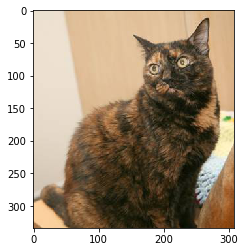

In [25]:
# view sample data and check distribution of validation set
train_dir = './train'
sample_dataset = CatsDogsDataSet(train_dir=train_dir, transform = train_transform)  
rand_index = random.randint(0, len(sample_dataset))
sample_image, sample_label = sample_dataset.__getitem__(rand_index)

print("Shape: ", sample_image.shape)
split = sample_dataset.split(20001,25000)

print("Split: ", sum(split))

print(sample_label)
sample = sample_dataset.show_image(rand_index)

In [26]:
batch_size = 32

# create datasets from np arrays
train_dataset = CatsDogsDataSet('train', transform=train_transform)
test_dataset = CatsDogsDataSet('test1', transform=test_transform)

train_indexes =  [i for i in range(24000)]
valid_indexes =  [i for i in range(24000, 25000)]

train_data = Subset(train_dataset, train_indexes)
valid_data  = Subset(train_dataset, valid_indexes)

# torch dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,50,5)
        self.conv2 = nn.Conv2d(50,150,3)
        self.conv3 = nn.Conv2d(150,300,3)
        self.conv4 = nn.Conv2d(300, 120, 3)
        self.fc1 = nn.Linear(3000, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear (512, 2)
    
        
    def forward(self,x): 
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size = 3, stride = 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size = 3, stride = 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size = 3, stride = 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size = 3, stride = 2)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print(CNN())

CNN(
  (conv1): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(50, 150, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(150, 300, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(300, 120, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)


In [28]:
model = CNN()    
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
expr_lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [3, 7], gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [29]:
loss_list = []
accuracy_list = []
iteration_list = []

def train(epoch):
    model.train()
    expr_lr_scheduler.step()
    i = 0
    for features, labels in tqdm(train_loader):
        print(i)
        features, labels = Variable(features), Variable(labels)
        if torch.cuda.is_available():
            features = features.cuda()
            labels = labels.cuda()

        # zero out gradients from previous iteration
        optimizer.zero_grad()

        # forward propagation
        output = model(features)
        
        # calculate loss
        loss = criterion(output, labels)

        # backprop
        loss.backward()
        
        # update params (gradient descent)
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            evaluate(valid_loader)
            
        i += 1

In [30]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for features, labels in tqdm(data_loader):
        with torch.no_grad():
            features, labels = Variable(features), Variable(labels)
            if torch.cuda.is_available():
                features = features.cuda()
                labels = features.cuda()
            output = model(features)
            
        loss += F.cross_entropy(output, labels, size_average=False).data.item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    print('Epoch: {}, Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
        epoch,
        loss, correct, len(data_loader.dataset),
        accuracy))
    loss_list.append(loss)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)

In [31]:
n_epochs = 10

for epoch in range(n_epochs):
    train(epoch)
    evaluate(valid_loader)

0%|          | 0/750 [00:52<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# visualize loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")
plt.show()

# visualize accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of epochs")
plt.show()

In [ ]:
# save model
torch.save(model, 'cnn-model.pt')